In [1]:
catName = 'low'

In [2]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist
from gridVarQ2Plot import col_dic
from progressBar import ProgressBar
from categoriesDef import categories

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 5*' ' + 'Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [4]:
m_pi = 0.13957062
m_K = 0.493677
m_D0 = 1.86483
m_Dst = 2.01026

In [5]:
catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
df = pd.DataFrame(rtnp.root2array('../data/cmsRD/skimmed/B2DstMu_200320_Low_skip8-14-15.root'))

In [8]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/'
loc += 'ntuples_B2DstMu/skimmed/Low_skip8-14-15.root'
df_MC = pd.DataFrame(rtnp.root2array(loc))

In [9]:
'  '.join(df.columns)

'index  q2  Est_mu  M2_miss  mu_pt  mu_eta  mu_phi  mu_sigdxy  B_pt  B_eta  B_phi  Dst_pt  Dst_eta  Dst_phi  D0_pt  D0_eta  D0_phi  pi_pt  pi_eta  pi_phi  pi_IP  K_pt  K_eta  K_phi  K_IP  pval_piK  sigdxy_vtxD0_PV  pis_pt  pis_eta  pis_phi  pis_IP  pval_D0pis  mass_piK  mass_D0pis  mass_D0pismu  pval_D0pismu  cos_D0pismu_PV  cosT_D0pismu_PV  N_lowMassAddTks  cat_low  cat_mid  cat_high  N_vtx'

In [10]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2DstMu_200320*')
lumi_tot = getLumiByTrigger(datasets_loc, categories[catName].trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200320
HLT_Mu7_IP4_part4_v2 1.28
Total lumi: 1.28 fb^-1


# General plots

<ROOT.TLine object ("TLine") at 0xb4562e0>

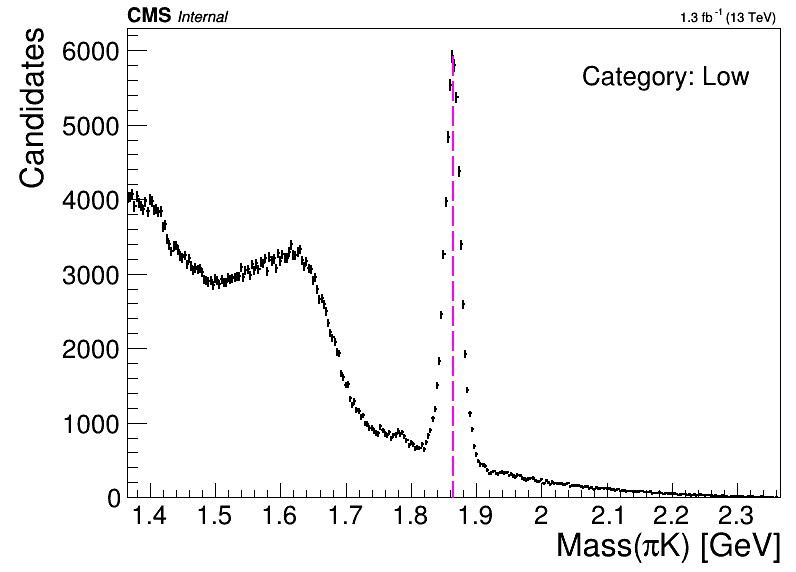

In [11]:
h = create_TH1D(df['mass_piK'], binning=[300, m_D0-0.5, m_D0+0.5], axis_title=['Mass(#piK) [GeV]', 'Candidates'])
c = drawOnCMSCanvas(CMS_lumi, [h])
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
cl.DrawLine(m_D0, 0, m_D0, h.GetMaximum())

<ROOT.TLine object ("TLine") at 0x97e5490>

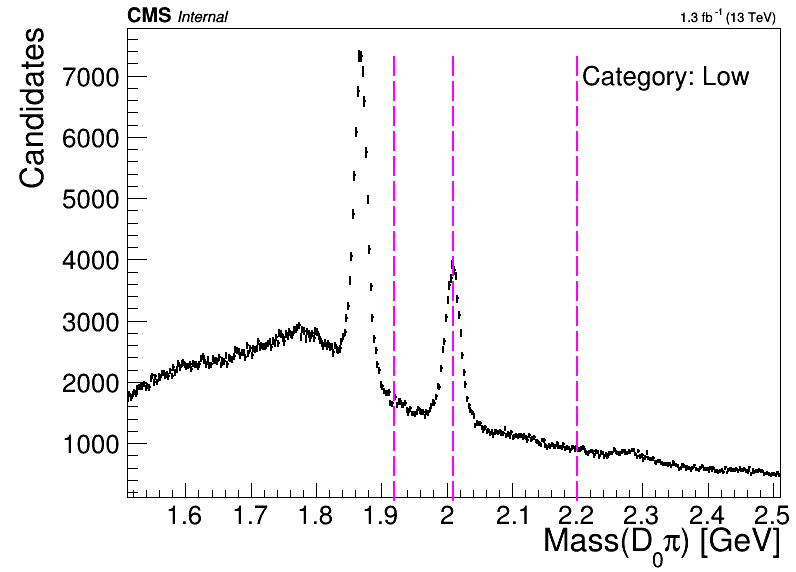

In [12]:
h = create_TH1D(df['mass_D0pis'], binning=[400, m_Dst-0.5, m_Dst+0.5], axis_title=['Mass(D_{0}#pi) [GeV]', 'Candidates'])
c = drawOnCMSCanvas(CMS_lumi, [h])
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
cl.DrawLine(1.92, 0, 1.92, h.GetMaximum())
cl.DrawLine(2.2, 0, 2.2, h.GetMaximum())
cl.DrawLine(m_Dst, 0, m_Dst, h.GetMaximum())

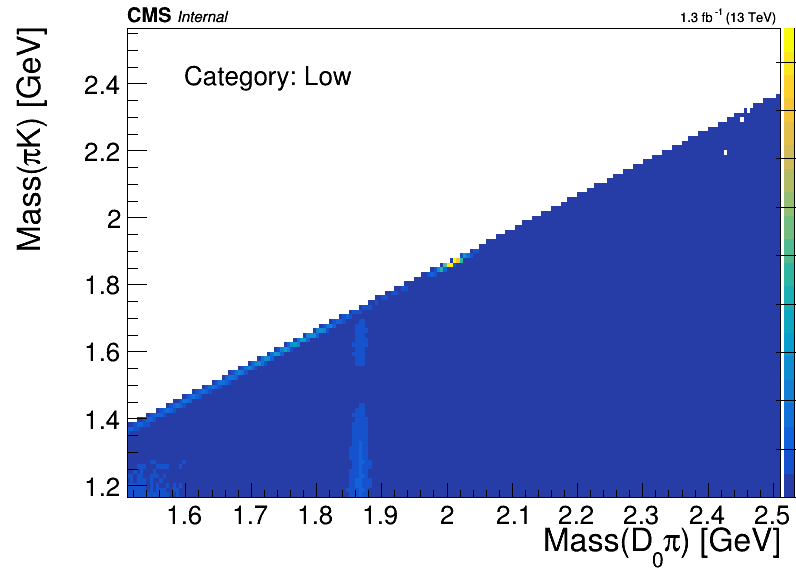

In [13]:
h = create_TH2D(np.column_stack((df['mass_D0pis'], df['mass_piK'])), 
                binning=[200, m_Dst-0.5, m_Dst+0.5, 100, m_D0-0.7, m_D0+0.7], 
                axis_title=['Mass(D_{0}#pi) [GeV]', 'Mass(#piK) [GeV]', 'Candidates'])
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
catText.DrawLatexNDC(0.45, 0.85, 'Category: Low')
h.Sumw2()

In [14]:
delta_M = df['mass_D0pis'] - df['mass_piK']
delta_M_MC = df_MC['mass_D0pis'] - df_MC['mass_piK']

<ROOT.TLine object ("TLine") at 0xb762510>

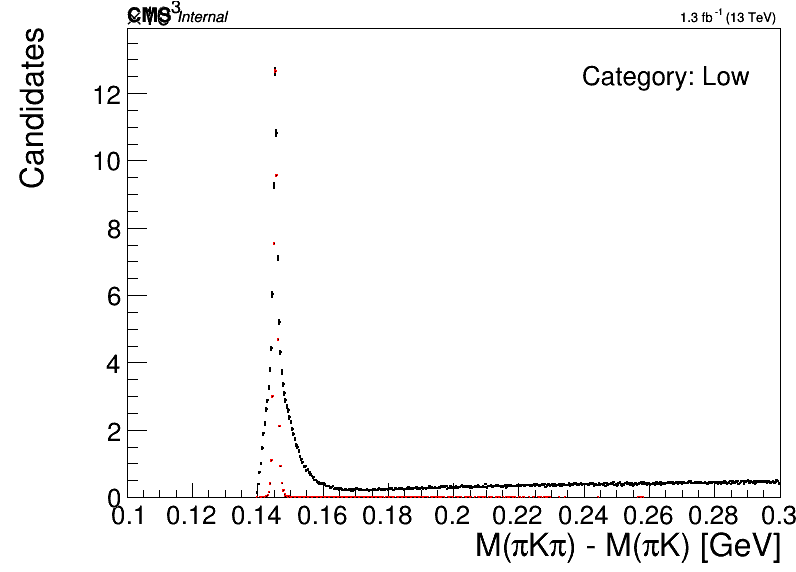

In [15]:
h = create_TH1D(delta_M, 'data',
                binning=[500, 0.1, 0.3], 
                axis_title=['M(#piK#pi) - M(#piK) [GeV]', 'Candidates'])


h_MC = create_TH1D(delta_M_MC, 'MC', binning=h.binning)
h_MC.Scale(h.GetMaximum()/h_MC.GetMaximum())
h_MC.SetLineColor(2)
hl = [h, h_MC]
m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
cl.DrawLine(1.92, 0, 1.92, h.GetMaximum())
cl.DrawLine(2.2, 0, 2.2, h.GetMaximum())
cl.DrawLine(m_Dst, 0, m_Dst, h.GetMaximum())

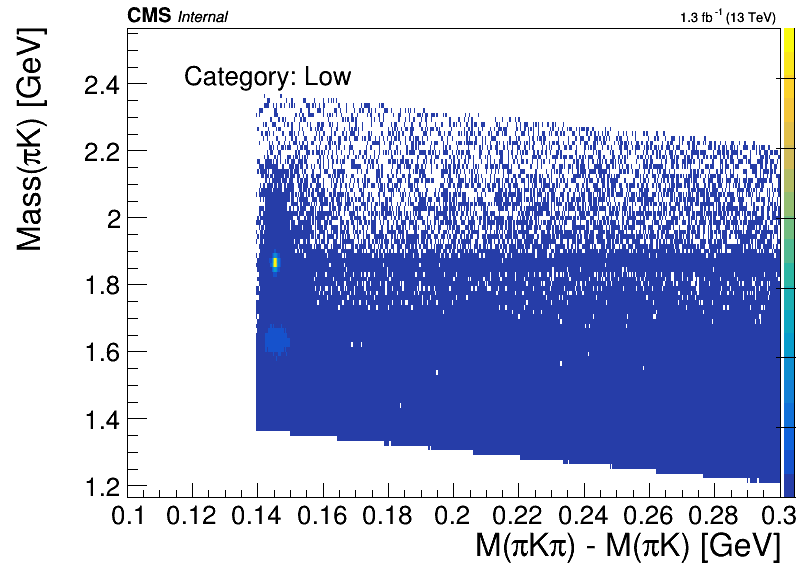

In [16]:
h = create_TH2D(np.column_stack((delta_M, df['mass_piK'])), 
                binning=[500, 0.1, 0.3, 100, m_D0-0.7, m_D0+0.7], 
                axis_title=['M(#piK#pi) - M(#piK) [GeV]', 'Mass(#piK) [GeV]', 'Candidates'])
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
catText.DrawLatexNDC(0.45, 0.85, 'Category: Low')
h.Sumw2()

# Clean $D_0$ distribution

In [17]:
def masspiK_varM(m1_pi=m_pi, m2_K=m_K):
    E1 = np.hypot(m1_pi, df['pi_pt']*np.cosh(df['pi_eta']))
    E2 = np.hypot(m2_K, df['K_pt']*np.cosh(df['K_eta']))
    p1p2 = df['pi_pt']*df['K_pt']
    p1p2 *= np.cos(df['pi_phi'] - df['K_phi']) + np.sinh(df['pi_eta'])*np.sinh(df['K_eta'])
    
    M = m1_pi**2 + m2_K**2 + 2*(E1*E2 - p1p2)
    return np.sqrt(M)

m_pipi = masspiK_varM(m_pi, m_pi)
m_KK = masspiK_varM(m_K, m_K)

In [18]:
def masspiK_varM_MC(m1_pi=m_pi, m2_K=m_K):
    E1 = np.hypot(m1_pi, df_MC['pi_pt']*np.cosh(df_MC['pi_eta']))
    E2 = np.hypot(m2_K, df_MC['K_pt']*np.cosh(df_MC['K_eta']))
    p1p2 = df_MC['pi_pt']*df_MC['K_pt']
    p1p2 *= np.cos(df_MC['pi_phi'] - df_MC['K_phi']) + np.sinh(df_MC['pi_eta'])*np.sinh(df_MC['K_eta'])
    
    M = m1_pi**2 + m2_K**2 + 2*(E1*E2 - p1p2)
    return np.sqrt(M)

m_pipi_MC = masspiK_varM_MC(m_pi, m_pi)
m_KK_MC = masspiK_varM_MC(m_K, m_K)

<ROOT.TLine object ("TLine") at 0xb426b00>

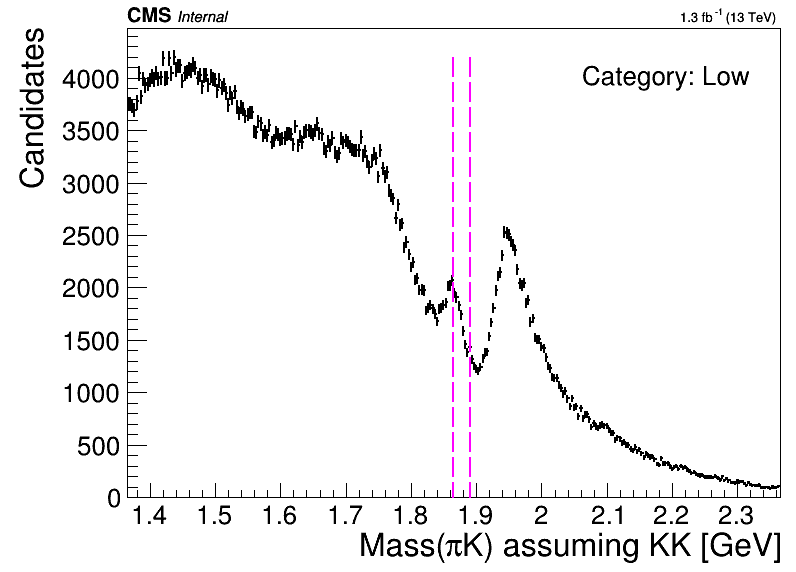

In [19]:
h = create_TH1D(masspiK_varM(m_K, m_K), 
                binning=[300, m_D0-0.5, m_D0+0.5], 
                axis_title=['Mass(#piK) assuming KK [GeV]', 'Candidates'])
c = drawOnCMSCanvas(CMS_lumi, [h])
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
cl.DrawLine(m_D0, 0, m_D0, h.GetMaximum())
cl.DrawLine(1.89, 0, 1.89, h.GetMaximum())

<ROOT.TLine object ("TLine") at 0xb7634f0>

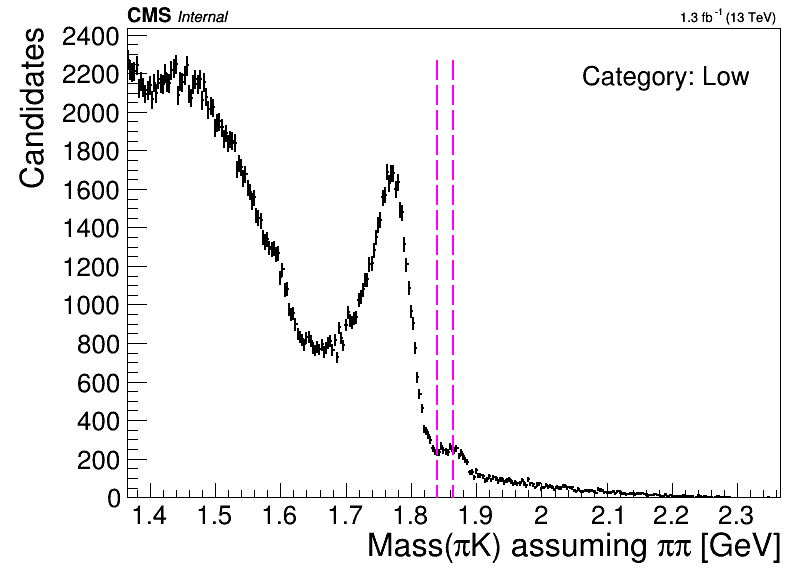

In [20]:
h = create_TH1D(masspiK_varM(m_pi, m_pi), 
                binning=[300, m_D0-0.5, m_D0+0.5], 
                axis_title=['Mass(#piK) assuming #pi#pi [GeV]', 'Candidates'])
c = drawOnCMSCanvas(CMS_lumi, [h])
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
cl.DrawLine(m_D0, 0, m_D0, h.GetMaximum())
cl.DrawLine(1.84, 0, 1.84, h.GetMaximum())

<ROOT.TLine object ("TLine") at 0xb7634f0>

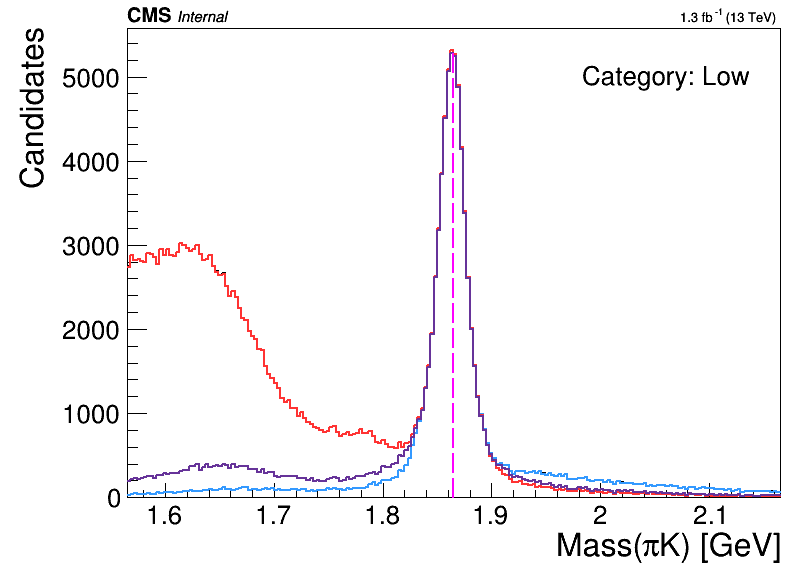

In [21]:
hlist = []

h = create_TH1D(df['mass_piK'], 'bare', binning=[200, m_D0-0.3, m_D0+0.3], axis_title=['Mass(#piK) [GeV]', 'Candidates'])
hlist.append(h)

sel = np.abs(df['mass_piK'] - m_D0) < np.abs(m_KK - m_D0)
h = create_TH1D(df['mass_piK'][sel], 'noKK', binning=h.binning)
h.SetLineColor(col_dic.values()[0])
hlist.append(h)

sel = np.abs(df['mass_piK'] - m_D0) < np.abs(m_pipi - m_D0)
h = create_TH1D(df['mass_piK'][sel], 'nopipi', binning=h.binning)
h.SetLineColor(col_dic.values()[1])
hlist.append(h)

sel = np.logical_and(m_KK > 1.89, m_pipi<1.84)
h = create_TH1D(df['mass_piK'][sel], 'hcut', binning=h.binning)
h.SetLineColor(col_dic.values()[2])
hlist.append(h)

c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
cl.DrawLine(m_D0, 0, m_D0, h.GetMaximum())

# $D^*$ cleaning

In [22]:
sel_D0decay = np.logical_and(m_KK > 1.91, m_pipi<1.83)
sel_D0mass = np.abs(df['mass_piK'] - m_D0) < 0.05
sel_D0 = np.logical_and(sel_D0decay, sel_D0mass)
np.sum(np.column_stack((sel_D0mass, sel_D0decay, sel_D0)), axis=0)

array([65422, 96844, 62328])

<ROOT.TLine object ("TLine") at 0xb776c60>

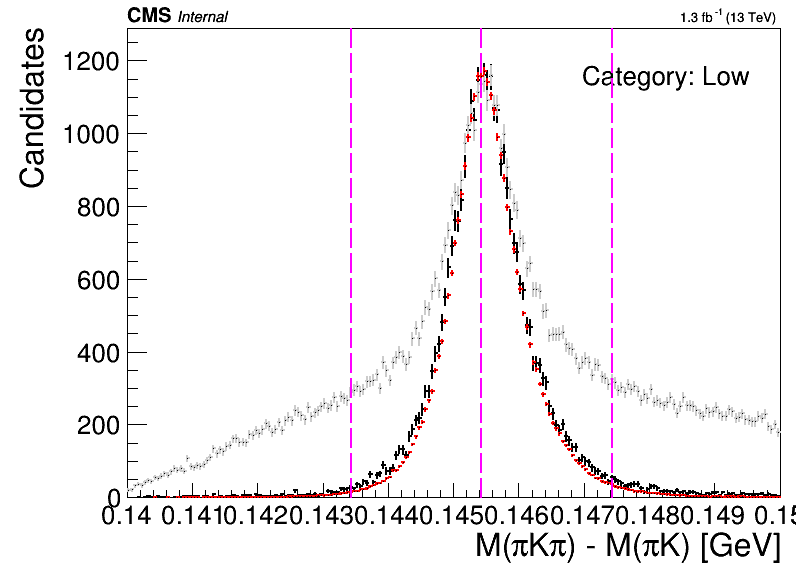

In [23]:
h = create_TH1D(delta_M[sel_D0], 'data',
                binning=[200, 0.14, 0.15], 
                axis_title=['M(#piK#pi) - M(#piK) [GeV]', 'Candidates'])

h_bare = create_TH1D(delta_M, 'databare', binning=h.binning)
h_bare.SetLineColor(rt.kGray)
h_bare.Scale(h.GetMaximum()/h_bare.GetMaximum())

h_MC = create_TH1D(delta_M_MC, 'MC', binning=h.binning)
h_MC.Scale(1.01*h.GetMaximum()/h_MC.GetMaximum())
h_MC.SetLineColor(2)
hl = [h, h_bare, h_MC]
m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
dm = m_Dst - m_D0
cl.DrawLine(dm-0.002, 0, dm-0.002, h.GetMaximum())
cl.DrawLine(dm+0.002, 0, dm+0.002, h.GetMaximum())
cl.DrawLine(dm, 0, dm, h.GetMaximum())

<ROOT.TLine object ("TLine") at 0xb776c60>

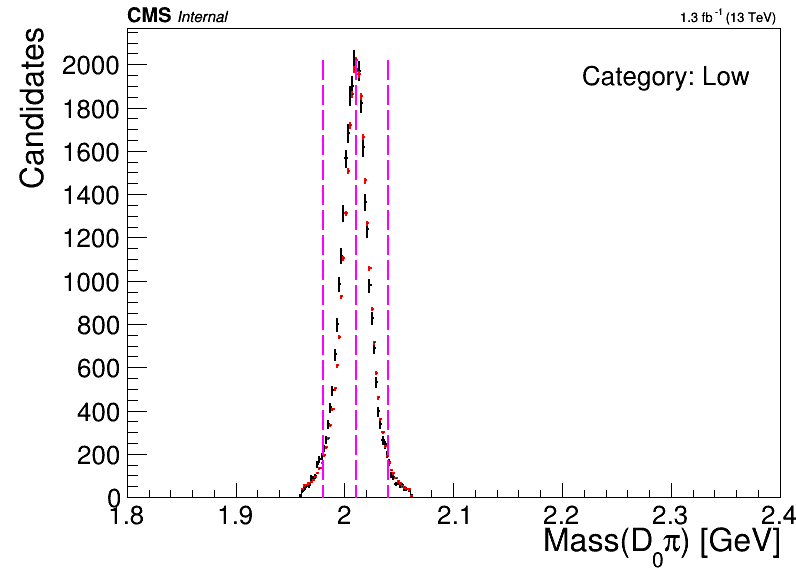

In [24]:
sel_aux = np.logical_and(sel_D0, np.abs(delta_M -dm) < 0.002)
h = create_TH1D(df['mass_D0pis'][sel_aux], 
                binning=[300, 1.8, 2.4], 
                axis_title=['Mass(D_{0}#pi) [GeV]', 'Candidates'])

h_MC = create_TH1D(df_MC['mass_D0pis'], 'MC', binning=h.binning)
h_MC.Scale(h.GetMaximum()/h_MC.GetMaximum())
h_MC.SetLineColor(2)

c = drawOnCMSCanvas(CMS_lumi, [h, h_MC], 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
cl.DrawLine(m_Dst+0.03, 0, m_Dst+0.03, h.GetMaximum())
cl.DrawLine(m_Dst-0.03, 0, m_Dst-0.03, h.GetMaximum())
cl.DrawLine(m_Dst, 0, m_Dst, h.GetMaximum())

# Closure plot

In [25]:
sel_D0decay = np.logical_and(m_KK > 1.91, m_pipi<1.83)
sel_D0mass = np.abs(df['mass_piK'] - m_D0) < 0.05
sel_D0 = np.logical_and(sel_D0decay, sel_D0mass)

sel_deltaM = np.abs(delta_M - (m_Dst-m_D0)) < 0.002
sel_Dstmass = np.abs(df['mass_D0pis'] - m_Dst) < 0.3

sel_final = np.logical_and(sel_deltaM, sel_Dstmass)
sel_final = np.logical_and(sel_final, sel_D0)

In [26]:
sel_D0decay = np.logical_and(m_KK_MC > 1.91, m_pipi_MC<1.83)
sel_D0mass = np.abs(df_MC['mass_piK'] - m_D0) < 0.05
sel_D0 = np.logical_and(sel_D0decay, sel_D0mass)

sel_deltaM = np.abs(delta_M_MC - (m_Dst-m_D0)) < 0.002
sel_Dstmass = np.abs(df_MC['mass_D0pis'] - m_Dst) < 0.3

sel_final_MC = np.logical_and(sel_D0mass, sel_Dstmass)
sel_final_MC = np.logical_and(sel_final_MC, sel_deltaM)

S = np.sum(sel_final)/float(np.sum(sel_final_MC))

<ROOT.TLine object ("TLine") at 0xb7634f0>

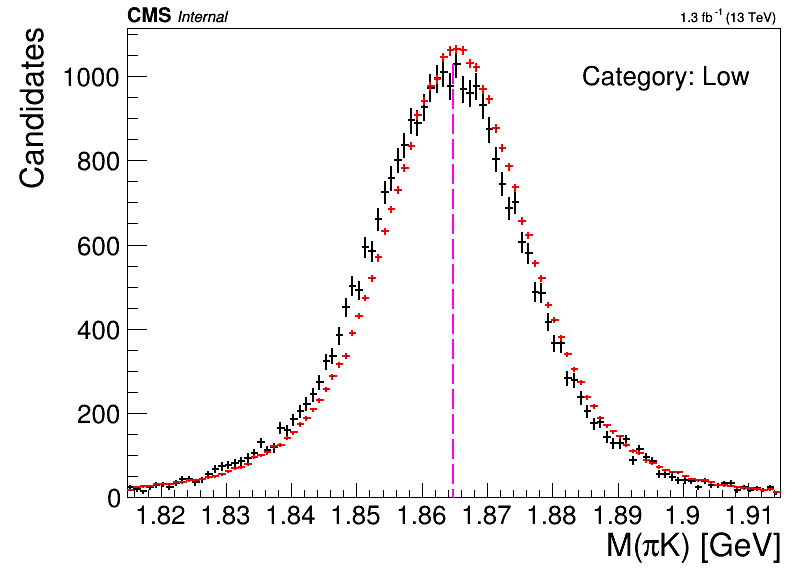

In [27]:
h = create_TH1D(df['mass_piK'][sel_final], 
                binning=[100, m_D0-0.05, m_D0+0.05], 
                axis_title=['M(#piK) [GeV]', 'Candidates'])

h_MC = create_TH1D(df_MC['mass_piK'][sel_final_MC], 'MC', binning=h.binning, scale_histo=S)
h_MC.SetLineColor(2)

c = drawOnCMSCanvas(CMS_lumi, [h, h_MC], 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
cl.DrawLine(m_D0, 0, m_D0, h.GetMaximum())

<ROOT.TLine object ("TLine") at 0xb75a300>

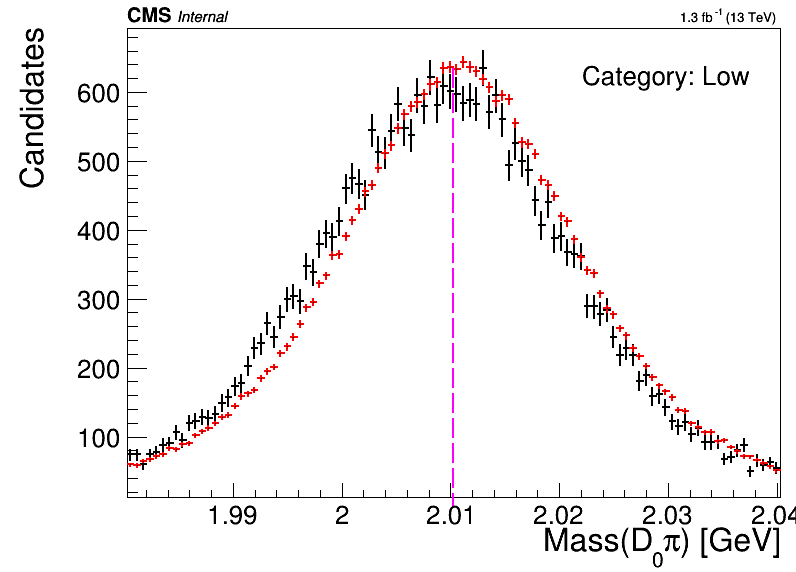

In [28]:
h = create_TH1D(df['mass_D0pis'][sel_final], 
                binning=[100, m_Dst-0.03, m_Dst+0.03], 
                axis_title=['Mass(D_{0}#pi) [GeV]', 'Candidates'])

h_MC = create_TH1D(df_MC['mass_D0pis'][sel_final_MC], 'MC', binning=h.binning, scale_histo=S)
h_MC.SetLineColor(2)

c = drawOnCMSCanvas(CMS_lumi, [h, h_MC], 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
cl.DrawLine(m_Dst, 0, m_Dst, h.GetMaximum())

<ROOT.TLine object ("TLine") at 0xb75a300>

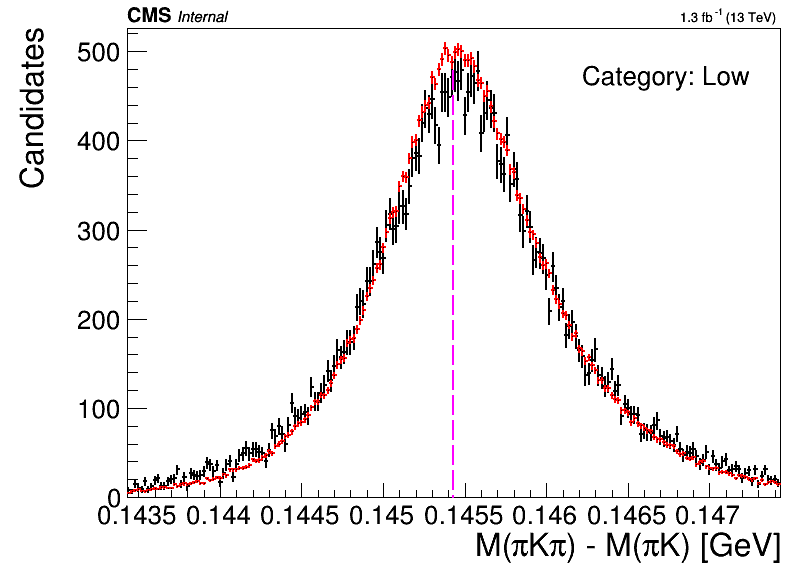

In [29]:
h = create_TH1D(delta_M[sel_final], 'data',
                binning=[200, dm - 0.002, dm + 0.002], 
                axis_title=['M(#piK#pi) - M(#piK) [GeV]', 'Candidates'])


h_MC = create_TH1D(delta_M_MC[sel_final_MC], 'MC', binning=h.binning, scale_histo=S)
h_MC.SetLineColor(2)

c = drawOnCMSCanvas(CMS_lumi, [h, h_MC], 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
cl.DrawLine(dm, 0, dm, h.GetMaximum())

# Fit (deprecated)

In [30]:
raise

TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

In [ ]:
sel = np.logical_and(m_KK > 1.91, m_pipi<1.84)

# sel = np.logical_and(
#     np.abs(df['mass_piK'] - m_D0) < np.abs(m_pipi - m_D0),
#     np.abs(df['mass_piK'] - m_D0) < np.abs(m_KK - m_D0)
# )

h = create_TH1D(df['mass_piK'][sel], 'hcut', binning=[100, 1.75, 1.96])

mass = rt.RooRealVar('mass_piK', 'm_{#piK}', h.binning[1], h.binning[2], 'GeV')

mean = rt.RooRealVar('mean', '#mu', m_D0, 1, 5, 'GeV')
sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', 0.02, 0.00005, 0.1, 'GeV') 
sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', 0.06, 0.00005, 0.1, 'GeV') 
gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.01, 0.99)
pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))

N_tot = h.Integral(1, h.GetNbinsX())
nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [ ]:
# lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
# pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)

a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
a1 = rt.RooRealVar('a1', 'a1', -0.1, -10, 100)
pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(a0, a1), 0)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

In [ ]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())
N_sig_per_fb = nsig.getVal()/lumi_tot
dN_sig_per_fb = nsig.getError()/lumi_tot
print 'Signal events per fb: {:.0f}'.format(N_sig_per_fb)

In [ ]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()), rf.MarkerStyle(15))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(1))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

x_min = h.binning[1] + (h.binning[-1]-h.binning[1])*0.03
x_max = h.binning[1] + (h.binning[-1]-h.binning[1])*0.3
pTxt = rt.TPaveText(x_min, 0.2*h.GetMaximum(), x_max, h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))

pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaN.getVal(), 1e3*sigmaN.getError()))
pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaW.getVal(), 1e3*sigmaW.getError()))
pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_D0, 0, m_D0, h.GetMaximum());
pTxt.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')

In [ ]:
h2 = create_TH2D(np.column_stack((df['mass_D0pis'][sel], df['mass_piK'][sel])), 
                binning=[100, 1.92, 2.2, 100, 1.75, 1.96], 
                axis_title=['Mass(D_{0}#pi) [GeV]', 'Mass(#piK) [GeV]', 'Candidates'])
c = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'])
catText.DrawLatexNDC(0.45, 0.85, 'Category: Low')
h.Sumw2()